In [1]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from venn import venn
from collections import defaultdict
import itertools
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from adjustText import adjust_text
import matplotlib.patches as mpatches
from upsetplot import plot

# 0. Calculate weighted p-values for four models 

In [2]:
def read_table(file_path):
    return pd.read_csv(file_path, sep='\t')

In [3]:
def calculate_weighted_p_value(weights, p_values):
    return np.dot(weights, p_values)

## Read AICc values

In [4]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/'
aicc_file_path = 'AICc.v58_all.tsv'

aicc_df = read_table(dir_path + aicc_file_path)
# aicc_df = aicc_df[['gene', 'trans', 'default', 'srv']]
aicc_df.head(3)

,gene,trans,default,mh,srv,srv_mh
0,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN
1,A1CF,A1CF_rna-XM_003641458.4,24590.58,24899.83,23841.39,24164.13
2,A1CF,A1CF_rna-XM_015278705.2,21760.12,22068.15,21096.31,NaN


## Read results for all four models

In [5]:
gene_file = 'all.genes.pval.table.tsv'

results_files = {'default': f'v58/{gene_file}',
                 'mh':      f'v58_mh/{gene_file}',
                 'srv':     f'v58_srv/{gene_file}',
                 'srv_mh':  f'v58_srv_mh/{gene_file}'}

# results_files = {'default': f'v58/{gene_file}',
#                  'srv':     f'v58_srv/{gene_file}'}

results_dfs = {model: read_table(dir_path + file_path) for model, file_path in results_files.items()}

## Merge with AICc info

In [6]:
df_merged_1 = pd.merge(aicc_df, results_dfs['default'], on=['trans', 'gene'], how='left')

In [7]:
df_merged_2 = pd.merge(df_merged_1, results_dfs['srv'], on=['trans', 'gene', 'branch'], 
                       how='left', suffixes=('_default', '_srv'))

In [8]:
df_merged_3 = pd.merge(df_merged_2, results_dfs['mh'], on=['trans', 'gene', 'branch'], 
                       how='left', suffixes=('', '_mh')) 

In [9]:
merged_results = pd.merge(df_merged_3, results_dfs['srv_mh'], on=['trans', 'gene', 'branch'], 
                       how='left', suffixes=('', '_srv_mh'))

In [10]:
merged_results.head(3)

,gene,trans,default,mh,srv,srv_mh,branch,pval_default,pval_srv,pval,pval_srv_mh
0,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1,1.0,1.0,1.0,NaN
1,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1_HLparPun1,1.0,1.0,1.0,NaN
2,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1,1.0,1.0,1.0,NaN


In [11]:
merged_results = merged_results.rename(columns = {'pval':'pval_mh'})
merged_results.head(3)

,gene,trans,default,mh,srv,srv_mh,branch,pval_default,pval_srv,pval_mh,pval_srv_mh
0,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1,1.0,1.0,1.0,NaN
1,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1_HLparPun1,1.0,1.0,1.0,NaN
2,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1,1.0,1.0,1.0,NaN


## Calculate weighted p-values

In [12]:
models = ['default', 'mh', 'srv', 'srv_mh']
# models = ['default', 'srv']

merged_results['min_aic'] = merged_results[models].min(axis=1)

## Calculate AICc coefficients
for m in models:
    merged_results[f's_{m}'] = np.exp(0.5 * (merged_results['min_aic'] - merged_results[m])).fillna(0) 

## Calculate models weigths
merged_results['s_sum'] = merged_results['s_default'] + \
                        merged_results['s_mh'] + \
                        merged_results['s_srv'] + \
                        merged_results['s_srv_mh'] 
for m in models:
    merged_results[f'w_{m}'] = merged_results[f's_{m}'] / merged_results['s_sum']
    
## Calculate weighted p-values
merged_results['pval'] = [0] * merged_results.shape[0]

for m in models:
    p = merged_results[f'pval_{m}'].fillna(1.0)
    w = merged_results[f'w_{m}']
    merged_results['pval'] += p * w

merged_results.head(3)

,gene,trans,default,mh,srv,srv_mh,branch,pval_default,pval_srv,pval_mh,...,s_default,s_mh,s_srv,s_srv_mh,s_sum,w_default,w_mh,w_srv,w_srv_mh,pval
0,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
1,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1_HLparPun1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
2,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0


In [13]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/weighted_default_srv_mh/'
merged_results.to_csv(dir_path + 'all.genes.pval.table.tsv', index=False, sep='\t')

# aBSREL analysis

## 1. Read absrel final table

In [2]:
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v8_results/'
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v58_results/'
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v58_srv_results/'
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/combined_default_srv_mh/'
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/weighted_default_srv_mh/'

# file_name = 'validated.all.genes.pval.table.tsv'
file_name = 'all.genes.pval.table.tsv'
# file_name = 'combined.all.genes.pval.table.v58.tsv'

file_data = glob(dir_path + file_name)[0]
pval_tab = pd.read_csv(file_data, sep='\t')

pval_tab.head()

,gene,trans,default,mh,srv,srv_mh,branch,pval_default,pval_srv,pval_mh,...,s_default,s_mh,s_srv,s_srv_mh,s_sum,w_default,w_mh,w_srv,w_srv_mh,pval
0,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
1,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLacaPus1_HLparPun1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
2,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
3,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1_HLaraSol1,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0
4,A1CF,A1CF_ENSGALT00000057851.2,25172.56,25463.31,24498.38,NaN,HLamaAes1_HLnymHol2,1.0,1.0,1.0,...,4.014885e-147,2.938413e-210,1.0,0.0,1.0,4.014885e-147,2.938413e-210,1.0,0.0,1.0


## 2. Define groups of species: nectar vs control

In [3]:
# core nectar groups
hmmbrds = ["HLcalAnn5", "HLfloFus1", "HLphaSup1", "HLfloFus1_HLcalAnn5", "HLfloFus1_HLphaSup1"]
honeyeaters = ["HLlicMelCas1", "HLphyNov1", "HLgraPic1", "HLlicPen1",
             "HLlicMelCas1_HLgraPic1", "HLlicMelCas1_HLlicPen1", "HLlicMelCas1_HLphyNov1"]
# sunbirds = ["HLcinPul1", "HLlepAsp1", "HLlepAsp1_HLcinPul1", "HLdicExi1", "HLlepAsp1_HLdicExi1"]
sunbirds = ["HLlepAsp1", "HLdicExi1", "HLlepAsp1_HLdicExi1"]
nectar_parrots = ["HLtriMol2", "HLlorGal1", "HLamaAes1", "HLaraSol1",
          "HLamaAes1_HLaraSol1", "HLtriMol2_HLlorGal1", "HLamaAes1_HLtriMol2"]

# core nonnectar groups
swifts = ['HLapuApu1', 'HLchaPel1', 'HLchaPel1_HLapuApu1']
falcons = ['falPer1', 'falChe1', 'HLfalTin1', 'falPer1_falChe1', 'falPer1_HLfalTin1']
lyrebirds = ['HLatrCla1', 'HLmenNov1', 'HLatrCla1_HLmenNov1']
passerides = ['HLtaeGut4', 'pseHum1', 'ficAlb2', 'HLmelMel1_ficAlb2', 'HLparMaj1_pseHum1', 
              'HLmelMel1_HLparMaj1', 'HLmelMel1_HLtaeGut4', 'HLmelMel1_HLlepAsp1']

# ambiguous groups
songbirds = ["HLacaPus1", "HLacaPus1_HLparPun1", "HLlicMelCas1_HLacaPus1",
             "HLmalEle1", "HLmalCya1", "HLmalCya1_HLmalEle1", "HLcliRuf1"]
parrots_rest = ["HLnymHol2", "HLstrHab1", "HLamaAes1_HLnymHol2", "HLamaAes1_HLstrHab1"]
passerins = ["HLserCan1", "HLmelMel1", "HLmelMel1_HLserCan1", "HLparMaj1"]
flycatcher = ["HLempTra1"]
pardalote = ["HLparPun1"]

# nectar_br = hmmbrds + honeyeaters + pardalote + sunbirds + nectar_parrots
nectar_br = hmmbrds + honeyeaters + sunbirds + nectar_parrots
nonnectar = swifts + falcons + lyrebirds + passerides
ambiguous = parrots_rest + passerins + songbirds + flycatcher + pardalote

## 3. Calculate target (=relevance) ratio:
### Ratio = N target branches under selection / N total branches under selection

### Make gene dictionary: gene : percent of nectar takers under positive selection

In [4]:
## Keep only genes where at least one transcript has signal of selection (P < threshold) 
# pval_thresh = 0.05

# # Drop transc column; leave significant pvalues: <= threshold; group by gene
# df = pval_tab.drop('trans', axis=1).loc[pval_tab['pval'] <= pval_thresh].groupby('gene')
# gene_dict = dict(tuple(df))

In [92]:
## Keep only genes where at least 33% of transcripts have signal of selection (P < threshold)
# pval_thresh = 0.05
pval_thresh = 0.01

## Group by gene: all transcripts
pval_tab = pval_tab[['gene', 'trans', 'branch', 'pval']]

## Keep genes where at least 33% of transcripts have pval <= pval_thresh
selected_genes = []
for gene_branch, group in pval_tab.groupby(['gene', 'branch']):
    n_total = len(group)
    n_signif = (group['pval'] <= pval_thresh).sum()
    if n_signif / n_total >= 0.33:
        selected_genes.append(gene_branch[0])


In [93]:
## Now subset the original dataframe to only the selected genes
df = pval_tab[(pval_tab['gene'].isin(selected_genes)) & (pval_tab['pval'] < pval_thresh)].drop('trans', axis=1).groupby('gene')
gene_dict = dict(tuple(df))

In [94]:
def calc_target_ratio(target, target_clades):
    ## Takes target name and list of terget branches;
    ## Outputs a dict with gene: (ratio, branches under selection)
    
    ratio_target_dict = {}
    for g in gene_dict:
        count_target = 0
        count_out = 0
        for branch in list(gene_dict[g].branch):
            if branch in target_clades:
                count_target += 1
            if (branch not in target_clades ) and (branch not in ambiguous):
                count_out += 1
        if count_target != 0:
            ratio_target = count_target / (count_target + count_out)
            ratio_target_dict[g] = (ratio_target, set(gene_dict[g]['branch']))
    return(ratio_target_dict)

### Define target group (once!)

In [109]:
target = 'nonnectar'
# target = 'nectar'

if target == 'nectar':
    branches = nectar_br
elif target == 'nonnectar':
    branches = nonnectar

## get relevance reatio for target bracnches
ratio_target_dict = calc_target_ratio(target, branches)

### Plot Relevance Ratio

/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/weighted_default_srv_mh/0.01_ranked_genes_nonnectar_ratio.pdf


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


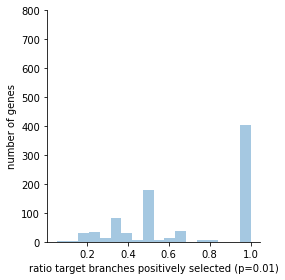

In [110]:
all_ratio_values = [v[0] for v in ratio_target_dict.values()]
fig, axes = plt.subplots(figsize=(4, 4))
sns.distplot(all_ratio_values, bins=18, kde=False)

axes.set_xlabel('ratio target branches positively selected (p={})'.format(pval_thresh))
axes.set_ylabel('number of genes')
axes.set_ylim(0, 800)

sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = "{}{}_ranked_genes_{}_ratio.pdf".format(dir_path, pval_thresh, target)
print(pdf_name)
# fig.savefig(pdf_name, bbox_inches='tight')


## 4. Output genes in dictionary that have target ratio above the threshold

In [111]:
# threshold = 0.5
# threshold = 0.6
threshold = 0.99
count = 0

out_dir = dir_path
out_file_name = 'under_selection_ranked_genes_{}_{}.tsv'.format(threshold, target)
out_file = out_dir + out_file_name

filtered_genes = []
with open(out_file, 'w') as ouf:
    for k, v in ratio_target_dict.items():
#     for k, v in sorted(ratio_target_dict.items(), key=lambda item: item[1]):
        if (v[0] > threshold):
            count += 1
            filtered_genes.append(k)
            out_line = '{}\t{}\t{}\n'.format(k, v[0], ','.join(list(v[1])))
            ouf.write(out_line)
            #print('{}\t{}'.format(k, v))

print('Number of genes above the {} threshold is: {}'.format(threshold, count))

Number of genes above the 0.99 threshold is: 404


## 5. Create filtered gene lists

In [112]:
if target == 'nectar':
    fg_list = [hmmbrds, honeyeaters, nectar_parrots, sunbirds]
    fg_names_list = ['hmmbrds', 'honeyeaters', 'nectar_parrots', 'sunbirds']

elif target == 'nonnectar':
    fg_list = [swifts, falcons, lyrebirds, passerides]
    fg_names_list = ['swifts', 'falcons', 'lyrebirds', 'passerides']

number_fg_in_clade = 1
per_clade_genes = defaultdict(list)

out_dir = dir_path
out_file_name = 'under_selection_per_clade_{}.{}.tsv'.format(pval_thresh, target)
out_file = out_dir + out_file_name

with open(out_file, 'w') as ouf:
    for i in range(len(fg_names_list)):
        fg = fg_list[i]
        fg_name = fg_names_list[i]
        for g in filtered_genes:
            branches = set(ratio_target_dict[g][1])
            if len(list(set(fg) & branches)) >= number_fg_in_clade:
                per_clade_genes[fg_name].append(g)
                ouf.write('{}\t{}\t{}\n'.format(fg_name, g, ','.join(ratio_target_dict[g][1])))

## 6. Plot intersection
### Venn diagram

/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/weighted_default_srv_mh/venn_genes_p_0.01_nonnectar_ratio_greater0.99.pdf


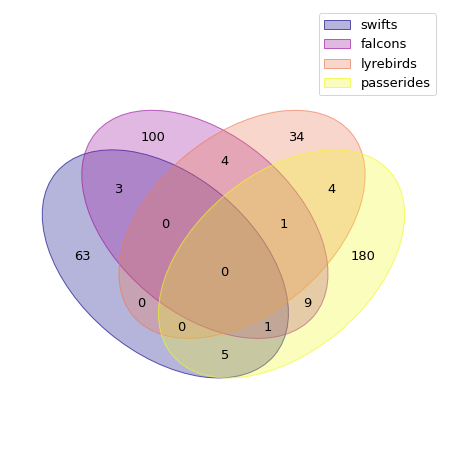

In [113]:
# convert lists to sets
for k in per_clade_genes:
    per_clade_genes[k] = set(per_clade_genes[k])
venn(per_clade_genes, cmap='plasma', alpha=0.3)

pdf_name = "{}venn_genes_p_{}_{}_ratio_greater{}.pdf".format(dir_path, pval_thresh, target, threshold)
print(pdf_name)
# plt.savefig("{}fg_2branches.venn_genes_p_{}_nectar_ratio_{}.noReg.pdf".format(dir_path, pval_thresh, threshold))
# plt.savefig("{}venn_genes_p_{}_nectar_ratio_{}.noReg.pdf".format(dir_path, pval_thresh, threshold))
# plt.savefig(pdf_name)

### Upset plot

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x14ba33490>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x14c1bd150>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x14c1bda10>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x14bd895d0>}

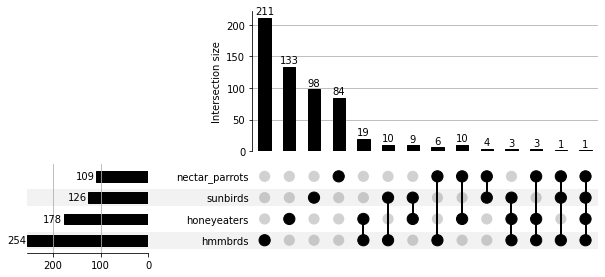

In [105]:
set1 = per_clade_genes['hmmbrds']
set2 = per_clade_genes['honeyeaters']
set3 = per_clade_genes['nectar_parrots']
set4 = per_clade_genes['sunbirds']

all_elems = set1.union(set2).union(set3).union(set4)
df = pd.DataFrame([[e in set1, 
                    e in set2, 
                    e in set3,
                    e in set4] for e in all_elems], columns = fg_names_list)
dfi = df.groupby(fg_names_list).size()

plot_size = 5
fig = plt.figure(figsize=(10, 5))
plot(dfi, fig=fig, orientation='horizontal', totals_plot_elements=plot_size, show_counts=True)    
#     plt.savefig("{}nectar_intersection.upsetplot.pdf".format(dir_path))



## 7. Perform Fisher-exact test for convergence

In [115]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/weighted_default_srv_mh/'
file_name = 'summary.matching_test_control.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

df['count'] = [len(i.split(',')) for i in df['pair']]
df.head(3)

,pair,type,value,count
0,"hmmbrds,honey",Odds Ratio,inf,2
1,"hmmbrds,honey",Confidence Interval,1.943451,2
2,"hmmbrds,honey",Confidence Interval,inf,2


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match D

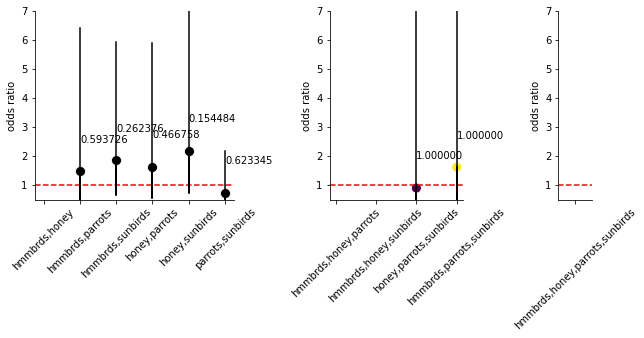

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4.8), gridspec_kw={'width_ratios': [6, 4, 1]})
directions = [2, 3, 4]

for i in range(3):
    axi = axes[i]
    d = directions[i]
    dfi = df[(df['count'] == d)]
    sns.scatterplot(ax=axi, data=dfi[dfi['type'] == 'Odds Ratio'], x='pair', y='value',
                    color='black', s=100)
#     axi.set_xticklabels(axi.get_xticklabels(), rotation=5)
    
    
    for p in set(dfi['pair']):
        ci_min = min(dfi[(dfi['pair'] == p)]['value'])
        ci_max = max(dfi[(dfi['pair'] == p)]['value'])
        odds = dfi[(dfi['pair'] == p) & (df['type'] == 'Odds Ratio')]['value']
        ci = dfi[(dfi['pair'] == p) & (df['type'] != 'P-Value')]['value']
        pval = list(dfi[(dfi['pair'] == p) & (df['type'] == 'P-Value')]['value'])[0]
        axi.errorbar(x=p, y=ci, color='black')
       
        ## annotate with p-values
#         axi.annotate("{:.1e}".format(pval), (p, odds + 5))
        axi.annotate("{:.6f}".format(pval), (p, odds + 1))
        
#     axi.set_ylim(0.5, 9)
    axi.set_ylim(0.5, 7)
    axi.set_ylabel('odds ratio')
    axi.set_xlabel('')
    axi.axhline(y=1, color = "red", linestyle = "dashed")

    axi.tick_params(axis='x', rotation=45)
sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = 'summary_Fexact.convergence.odds_ci_pval.pdf'


## 8. Check total branch length per group

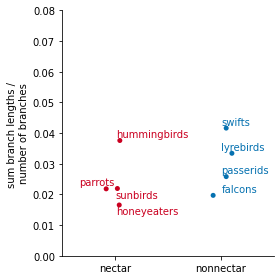

In [41]:
BL_df = pd.DataFrame.from_dict({'group': ['hummingbirds',
                           'honeyeaters', 
                           'parrots',
                           'sunbirds',
                           'swifts', 
                           'lyrebirds',
                           'passerids',
                           'falcons'],
                 'branch_length': [0.18795759,
                               0.11596274, 
                               0.15354985, 
                               0.1091534, 
                               0.1248886,
                               0.1002603,
                               0.20651251,
                               0.09851877],
                'branch_number': [5, 7, 7, 5, 3, 3, 8, 5],
                'type': ['nectar']*4 + ['nonnectar']*4})

BL_df['norm_BL'] = BL_df['branch_length'] / BL_df['branch_number']

p = ['#ca0020', '#0571b0']
sns.set_palette(p)
fig, axes = plt.subplots(figsize=(4, 4))
sns.stripplot(data=BL_df, x='type', y='norm_BL', dodge=True, jitter=0.15)


axes.set_ylim(0, 0.08)
axes.set_xlabel('')
axes.set_ylabel('sum branch lengths / \nnumber of branches')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


labels = []
for x, y, l in zip(BL_df['type'], BL_df['norm_BL'], BL_df['group']):
    if x == 'nectar':
        x = 0
        c = p[0]
    elif x == 'nonnectar':
        x = 1
        c = p[1]
    labels.append(axes.text(x=x, y=y, s=l, color=c, size=10))
adjust_text(labels, ax=axes)

fig.tight_layout()
plot_name = 'total_branch_length_nectar_vs_nonnectar.pdf'
# plt.savefig(plot_name, bbox_inches='tight')

## 10. Compare absrel versions

In [16]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/'

versions = ['v8_cinPul', 'v8', 'v58', 'v58_srv', 'v58_mh', 'v58_srv_mh']
all_results = {}

for v in versions:
    file_name = '{}/all.genes.pval.table.tsv'.format(v)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    pval_tab = pd.read_csv(file_data, sep='\t')
    all_results[v] = pval_tab

v8_cinPul/all.genes.pval.table.tsv
v8/all.genes.pval.table.tsv
v58/all.genes.pval.table.tsv
v58_srv/all.genes.pval.table.tsv
v58_mh/all.genes.pval.table.tsv
v58_srv_mh/all.genes.pval.table.tsv


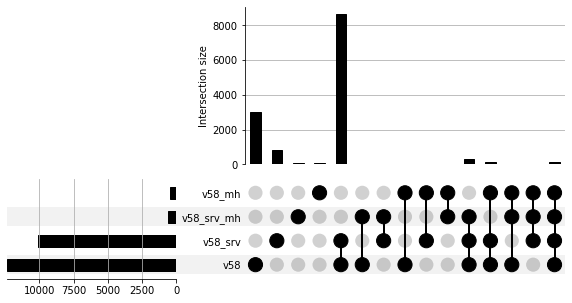

In [22]:

threshold = 0.05
level = 'trans'
# level = 'gene'

sets_by_version = {}

for v in versions:
    sets_by_version[v] = set(all_results[v][all_results[v]['pval'] < threshold][level])

# set5 = set(all_results['v58_srv'][all_results['v58_srv']['pval'] < threshold][level])
# set6 = set(all_results['v58_mh'][all_results['v58_mh']['pval'] < threshold][level])
# set7 = set(all_results['v58_srv_mh'][all_results['v58_srv_mh']['pval'] < threshold][level])
# set4 = set(all_results['combined_default_srv_mh'][all_results['combined_default_srv_mh']['pval'] < threshold][level])

# set1 = sets_by_version[versions[0]]
# set2 = sets_by_version[versions[1]]
# set3 = sets_by_version[versions[2]]

set4 = sets_by_version[versions[2]]
set5 = sets_by_version[versions[3]]
set6 = sets_by_version[versions[4]]
set7 = sets_by_version[versions[5]]

## Compare v8_cinPul v8 v58
# all_elems = set1.union(set2).union(set3)
# df = pd.DataFrame([[e in set1, 
#                     e in set2, 
#                     e in set3] for e in all_elems], columns = versions[:3])
# df_up = df.groupby(versions[:3]).size()


## Compare default srv mh srv+mh
all_elems = set4.union(set5).union(set6).union(set7)
df = pd.DataFrame([[e in set4, 
                    e in set5, 
                    e in set6,
                    e in set7] for e in all_elems], columns = versions[2:])
df_up = df.groupby(versions[2:]).size()


fig = plt.figure(figsize=(10, 5))
plot(df_up, fig=fig, orientation='horizontal', element_size=None, totals_plot_elements=8)


dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/'
# plt.savefig("{}{}.v8_cinPul.v8.v58.upsetplot.pdf".format(dir_path, level))
plt.savefig("{}{}.default.srv.mh.srv_mh.upsetplot.pdf".format(dir_path, level))

# RELAX analysis

In [3]:
import warnings

In [2]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/combined_default_srv_mh/'
file_name = 'all_relax_summary.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.head(3)

,gene,transcript,branches,K,pvalue,run
0,AADACL4L5,AADACL4L5_rna-XM_025142592.1,HLchaPel1_HLapuApu1,2.679841,1.557699e-03,1
1,AAREL,AAREL_rna-XM_015292890.2,"HLlepAsp1,ficAlb2,HLaraSol1,HLmelMel1",0.861289,1.164501e-01,1
2,AAREL,AAREL_rna-XM_015292892.2,"HLlepAsp1,ficAlb2,HLaraSol1,HLmelMel1",2.656527,3.733741e-08,1


## 1. Plot distributions of 9 RELAX runs 

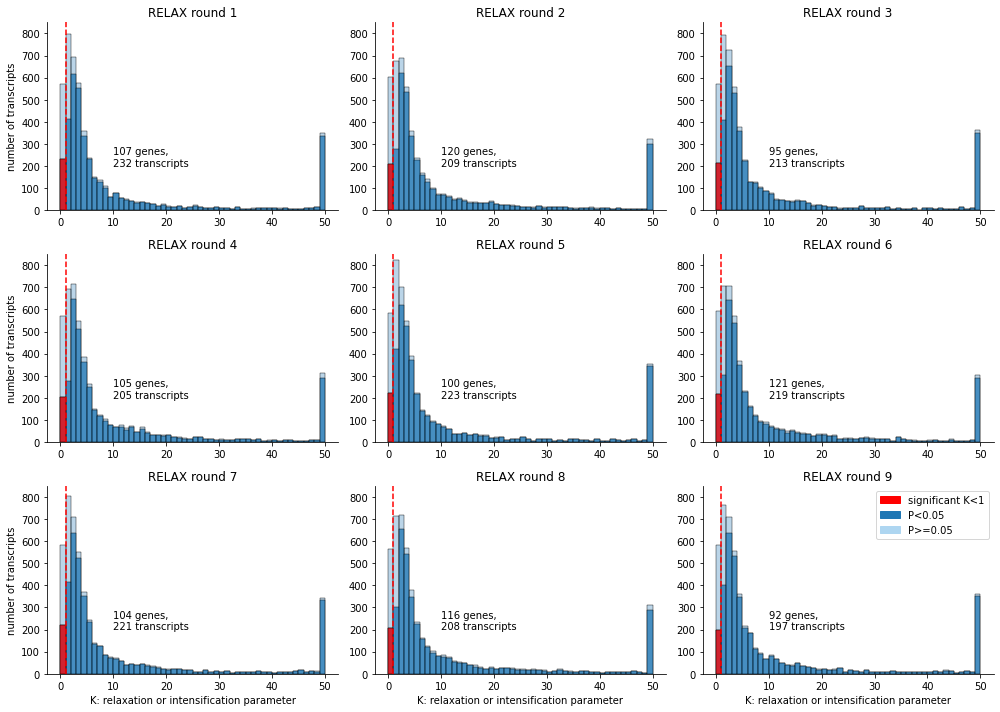

In [6]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i in range(9):
    j = i // 3
    k = i % 3
    axi = axes[j][k]
    
    dfi = df[df['run'] == i+1]
    sns.histplot(ax=axi, data=dfi, x='K', binwidth=1, alpha=0.3)
    sns.histplot(ax=axi, data=dfi[dfi['pvalue']<0.05], binwidth=1, x='K')
    sns.histplot(ax=axi, data=dfi[(dfi['pvalue']<0.05) & (df['K']<1)], binwidth=1, x='K', color='red')
    
    axi.set_ylim(0, 850)
    axi.axvline(x=1, color='red', ls='--')
    if j == 2:
        axi.set_xlabel('K: relaxation or intensification parameter')
    else:
        axi.set_xlabel('')
    if k == 0:
        axi.set_ylabel('number of transcripts')
    else:
        axi.set_ylabel('')

    # calcualte number of genes, transcripts with significant K<1
    n_genes = len(set(dfi[(dfi['pvalue']<0.05) & (df['K']<1)]['gene']))
    n_transc = len(set(dfi[(dfi['pvalue']<0.05) & (df['K']<1)]['transcript']))
    axi.text(10, 200, '{} genes,\n{} transcripts'.format(n_genes, n_transc))
    axi.set_title('RELAX round {}'.format(i+1))
    
# add custom legend
red_patch = mpatches.Patch(color='red', label='significant K<1')
blue_patch = mpatches.Patch(color='#1f77b4', label='P<0.05')
light_patch = mpatches.Patch(color='#aed6f1', label='P>=0.05')
plt.legend(handles=[red_patch, blue_patch, light_patch])
    
sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = 'RELAX_summary_9_runs.histograms.pdf'
# plt.savefig(pdf_name)

### Check overlap between default vs SRV; SRV vs weighted models; 

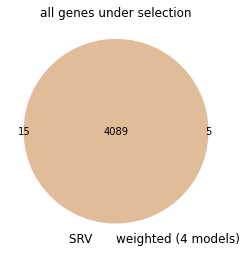

In [73]:
from matplotlib_venn import venn2

# venn_dict = {'all genes under selection': (1054, 247, 3857),
#              'under selection in nectar': (377, 304, 653),
#              'under selection in nonnectar': (348, 227, 439)}

venn_dict = {'all genes under selection': (15, 5, 4089)}

for i in venn_dict:
#     venn = venn2(subsets=venn_dict[i], set_labels=('default', 'SRV'))
    venn = venn2(subsets=venn_dict[i], set_labels=('SRV      ', 'weighted (4 models)'))
    plt.title(i)
    plt.show()

# Assembly stats nectar vs control

In [55]:
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/Manuscript_Nectar_Genomics/'
file_name = 'species_and_assemblies.nectar_project.stats.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.head(3)

,Common name,group,subgroup,Contig N50,Scaffold N50,g_complete,g_fragmented,g_missing,a_complete,a_fragmented,a_missing,intact RF
0,great tit,background,NaN,148693,71365269,96.4,1.0,2.6,98.97,0.43,0.60,12592
1,Tibetan ground-tit,control,sunbirds,165265,16337386,97.1,0.7,2.2,99.74,0.10,0.17,13382
2,song sparrow,background,NaN,181098,9239070,96.8,0.7,2.5,84.55,6.40,9.04,12379


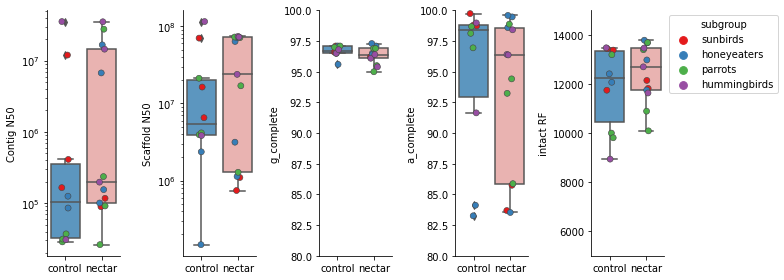

In [62]:
stats = ['Contig N50', 'Scaffold N50', 'g_complete', 'a_complete', 'intact RF']

fig, axes = plt.subplots(1, len(stats), figsize=(2.2*len(stats), 4))
p = ['#4b99d0', '#f2aaa8']
sns.set_palette(p)

p_4colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

for i in range(len(stats)):
    axi = axes[i]
    s = stats[i]
    dfi = df[df['group'] != 'background']
    
    sns.boxplot(ax=axi, data=dfi, y=s, x='group')
    sns.stripplot(ax=axi, data=dfi, y=s, x='group', hue='subgroup', s=6, linewidth=.6, palette=p_4colors)
    
    # adjust axes
    axi.set_xlabel('')
    if s.endswith('N50'):
        axi.set(yscale="log")
    elif s.endswith('complete'):
        axi.set_ylim(80, 100)
    else:
        axi.set_ylim(5000, 15000)
    
    # adjust legend
    if i != 4:
        axi.get_legend().set_visible(False)
    else:
        sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

        
sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = 'assembly_stats.nectar_vs_control.pdf'
# fig.savefig(dir_path + pdf_name, bbox_inches='tight')